# Import modules

In [1]:
# IMPORT PACKAGES
import pysheds
from pysheds.grid import Grid
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
# import fiona/
# import xarray as xr
# import shapefile
import math
# from scipy import stats
# import os

import netCDF4 as nc
from netCDF4 import Dataset
from shapely.geometry import Point, shape, box, mapping
from shapely.vectorized import contains
from shapely.strtree import STRtree
import matplotlib.path as mpath

from rasterio.coords import BoundingBox
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.features import shapes

In [2]:
def crop_dem(input_tif, output_tif, center_lon, center_lat,area):
    """
    Crop a GeoTIFF file around a specified coordinate (center_lon, center_lat), save the cropped image,
    display the cropped area, and plot a scatter point at the center coordinates.
    """

    # # Define the path to the input and output TIFF files
    # input_tiff = "path/to/your/input.tif"
    # output_tif = "path/to/your/output_cropped.tif"
    if area < 10000:
      width = np.sqrt(area)*4 # width extending from center point to each edge of square
    else:
      width = np.sqrt(area)*2

    width = int(width)
    degrees = np.round(width/111.32,2)

    xmin = center_lon - degrees
    xmax = center_lon + degrees
    ymin = center_lat - degrees
    ymax = center_lat + degrees

    # Define the bounding box coordinates (left, bottom, right, top)
    bbox = (xmin, ymin, xmax, ymax)  # Replace with actual coordinates

    # Open the source TIFF file
    with rasterio.open(input_tif) as src:
        # Convert the bounding box to a GeoJSON-style geometry for rasterio.mask.mask
        bbox_geom = {
            "type": "Polygon",
            "coordinates": [[
                [bbox[0], bbox[1]],
                [bbox[0], bbox[3]],
                [bbox[2], bbox[3]],
                [bbox[2], bbox[1]],
                [bbox[0], bbox[1]]
            ]]
        }

        # Crop the image using the bounding box geometry
        out_image, out_transform = mask(src, [bbox_geom], crop=True)
        out_meta = src.meta.copy()

        # Update metadata to reflect the new cropped area
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            'crs': src.crs  # Ensure the CRS remains the same
        })

        # # Save the cropped data to a new GeoTIFF file with updated profile
        # profile = src.profile
        # profile.update({
        #     'height': height,
        #     'width': width,
        #     'transform': transform,
        #     'crs': src.crs  # Ensure CRS is preserved
        # })

        with rasterio.open(output_tif, 'w', **out_meta) as dst:
            dst.write(out_image)


    fig, ax = plt.subplots(figsize=(10, 10))

    # Calculate the extent of the image in geographic coordinates
    left = out_transform.c  # xmin
    right = out_transform.c + out_transform.a * out_image.shape[2]  # xmax
    top = out_transform.f  # ymax
    bottom = out_transform.f + out_transform.e * out_image.shape[1]  # ymin

    extent = (left, right, bottom, top)

    # Plot the image using rasterio's show function
    show(out_image, transform=out_transform, extent=extent, ax=ax, cmap='gray')
    # Set axis labels
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    # Add a scatter point at the center coordinate
    plt.scatter(lon, lat, color='red', marker='o', s=100, label="Center Point")
    plt.title("Cropped GeoTIFF Area with Center Point")
    plt.title("Cropped Image")
    plt.show()

# Instatiate a grid

Data from USGS hydrosheds project: https://hydrosheds.cr.usgs.gov/datadownload.php

In [3]:
# Load DEM
dem_name = 'drive-download-20241124T110219Z-001/hyd_sa_dem_30s.tif'

# grid = Grid.from_raster('drive-download-20241124T110219Z-001/hyd_sa_dem_30s.tif', data_name='dem')
# dem = grid.read_raster('drive-download-20241124T110219Z-001/hyd_sa_dem_30s.tif')

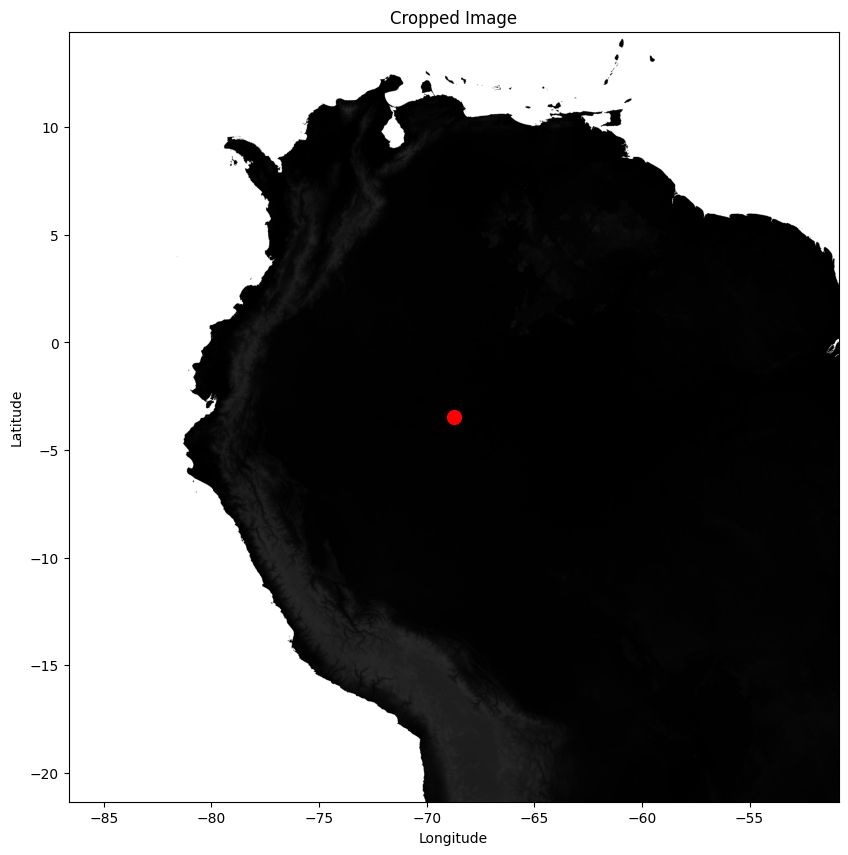

In [4]:
lon, lat = -68.75, -3.45
station_no = 3623100
area = 990781.0
out_name = 'drive-download-20241124T110219Z-001/hyd_sa_dem_30s_CROPPED.tif'
outimg = crop_dem(dem_name, out_name, lon, lat, area)

In [5]:
# Load DEM
grid = Grid.from_raster(out_name, data_name='dem')
dem = grid.read_raster(out_name)

# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

# Specify flow direction values

In [6]:
# Dirmap
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions from DEM
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)  # returns a Raster object
print(np.nanmin(fdir))
# Replace negative values with 0 (no flow)
# fdir = np.where(fdir < 0, 0, fdir)
# print(np.nanmin(fdir))
# Clean negative values inside the Raster
# fdir = grid.view(np.where(fdir.view() < 0, 0, fdir.view()), like=fdir)


-2


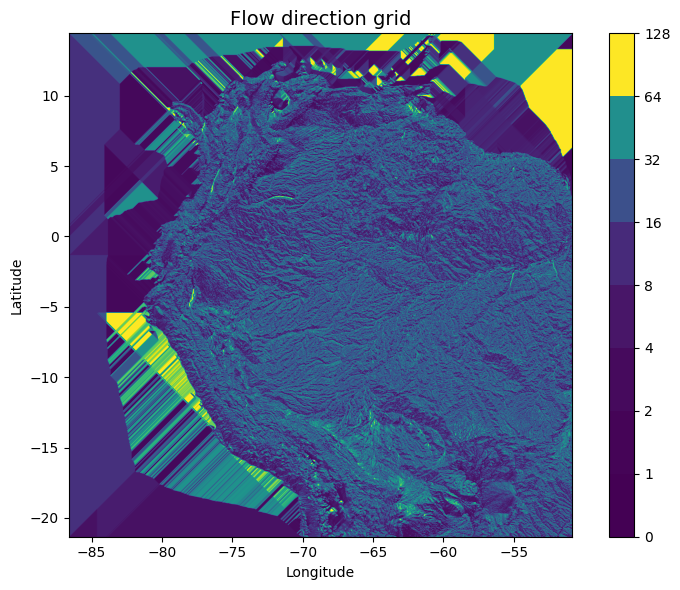

In [7]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
plt.scatter(lon, lat, color='red', marker='o', s=100, label="Center Point")
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

# Clip to a smaller area

In [8]:
# # Specify pour point
# # x, y = 17.72159144, -28.75798997
# # x, y = 17.722, -28.758
# x= lon
# y = lat

# # Delineate catchment
# catch = grid.catchment(x=x, y=y, fdir=fdir, dirmap=dirmap,
#                recursionlimit=15000, xytype='label', nodata_out=0)

# # Clip to catchment
# grid.clip_to(catch)

# # Flow accumulation
# grid.accumulation(fdir, dirmap=dirmap)

# Generate random points

In [9]:
yi_s = np.random.randint(0, grid.shape[0], size=10)
xi_s = np.random.randint(0, grid.shape[1], size=10)
xs, ys = grid.affine * (xi_s, yi_s)

# Delineate catchments at random points

In [10]:
z0 = np.zeros(grid.shape)
i = 0

for x, y in zip(xs, ys):
    i += 1
    c = grid.catchment(x=x, y=y, fdir=fdir, dirmap=dirmap, xytype='label', inplace=False)
    z0 += i * (c != 0).astype(int)

# Snap points to nearest high accumulation cells

In [11]:
acc = grid.accumulation(fdir, dirmap=dirmap)
acc[dem==0] = 0

In [12]:
mask = acc
print(np.sum(mask))   # number of True cells

18334009511.0


In [13]:
xy = np.column_stack([xs, ys])
# Snap pour point to high accumulation cell
acc_max = int(acc.max())
# print(acc_max)
power_ten = len(str(acc_max))
# print(power_ten)
snap_pt = 10**(int(power_ten) - 1)
# x_snap, y_snap = grid.snap_to_mask(acc > snap_pt, xy)
new_xy = grid.snap_to_mask(acc > snap_pt, xy, return_dist=False)
new_xs, new_ys = new_xy[:,0], new_xy[:,1]

# Delineate catchments at snapped points

In [14]:
z1 = np.zeros(grid.shape)
i = 0

for x, y in zip(new_xs, new_ys):
    i += 1
    c = grid.catchment(x, y, fdir=fdir, dirmap=dirmap, xytype='label', inplace=False)
    z1 += i * (c != 0).astype(int)

# Plot results

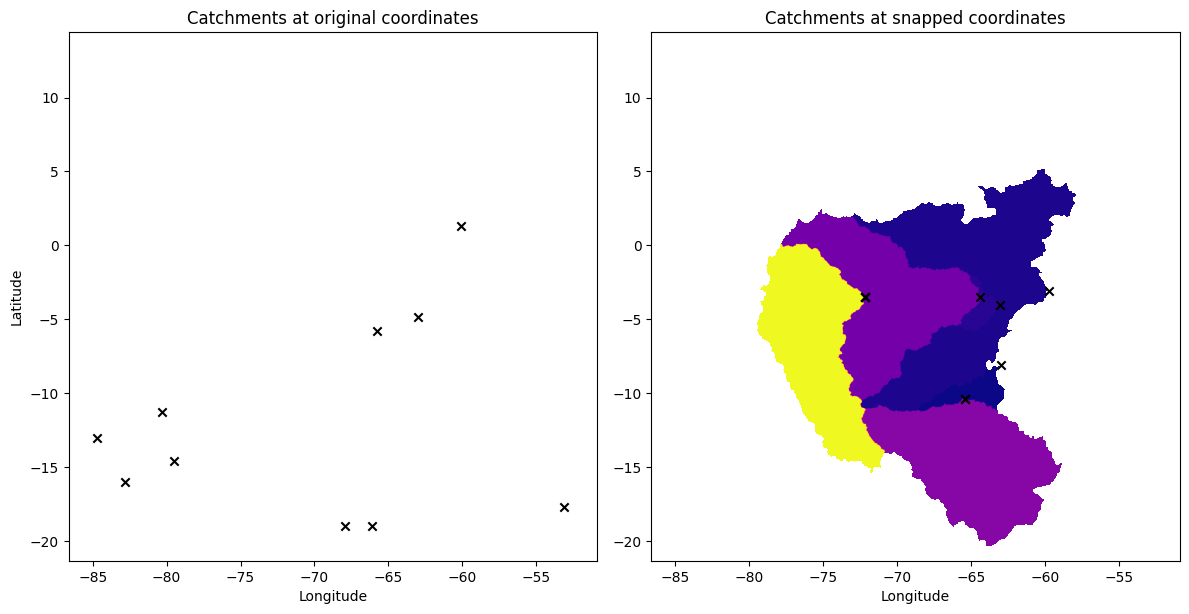

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

z0[z0 == 0] = np.nan
z1[z1 == 0] = np.nan

ax[0].imshow(z0, extent=grid.extent, zorder=1, cmap='plasma')
ax[0].scatter(xy[:,0], xy[:,1], marker='x', c='k', zorder=2)
ax[0].set_title('Catchments at original coordinates')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

ax[1].imshow(z1, extent=grid.extent, zorder=1, cmap='plasma')
ax[1].scatter(new_xy[:,0], new_xy[:,1], marker='x', c='k', zorder=2)
ax[1].set_title('Catchments at snapped coordinates')
ax[1].set_xlabel('Longitude')

plt.tight_layout()

Text(0, 0.5, 'Latitude')

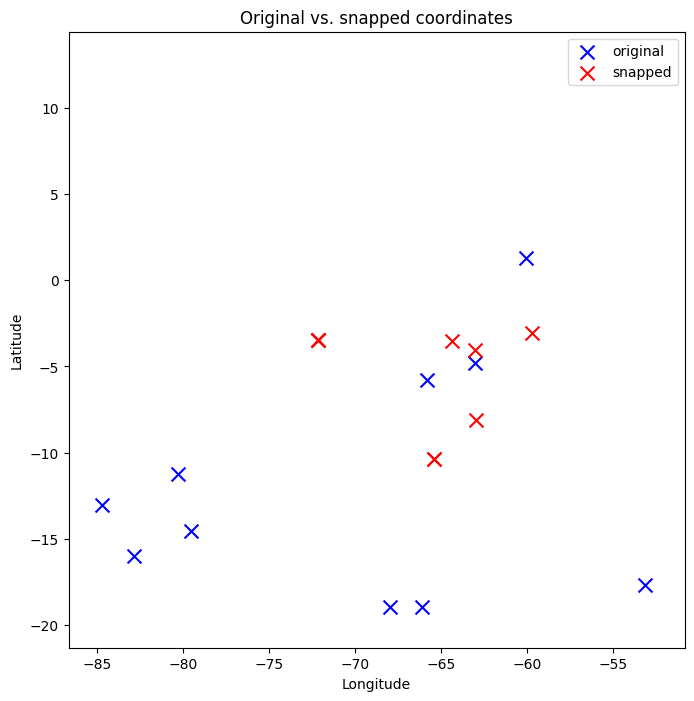

In [16]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')

plt.scatter(xs, ys, marker='x', c='b', s=100, label='original')
plt.scatter(new_xs, new_ys, marker='x', c='r', s=100, label='snapped')
plt.legend(frameon=True)
plt.imshow(np.where(acc > snap_pt, 1, np.nan), extent=grid.extent, cmap='bone', zorder=1, alpha=0.5)
plt.title('Original vs. snapped coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [17]:
x_snap, y_snap = grid.snap_to_mask(acc > snap_pt, (lon, lat))
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                          xytype='coordinate')
            
print(lon,lat)
print(x_snap, y_snap)

-68.75 -3.45
-68.75833333333335 -3.4333333333329286


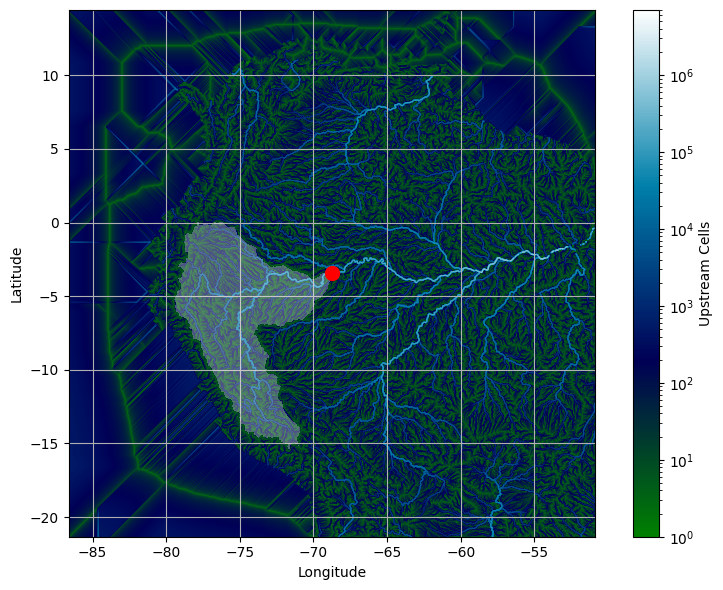

In [19]:
# # Clip the bounding box to the catchment
# grid.clip_to(catch)
catch_view = grid.view(catch, dtype=np.uint8)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=catch.extent, zorder=1,
                cmap='ocean',
                norm=colors.LogNorm(1, acc.max()),
                interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.imshow(np.where(catch_view,catch_view, np.nan), extent=grid.extent,zorder=2, cmap='Greys',alpha=0.3)
plt.scatter(x_snap,y_snap, color='red', s=100, marker='o', zorder=3)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()